# Import Libraries and Data

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

from plotly.subplots import make_subplots
import plotly.graph_objects as go


In [3]:
df_train = pd.read_csv(
    "./data/air_pollution/train.csv",
    usecols=range(5),
    index_col="Date",
    parse_dates=True,
    infer_datetime_format=True,
)


# Background Research

Air pollution is a serious issue that has equally serious implications. \
Poor air quality can directly cause cause shortness of breath, aggravate asthma and other respiratory conditions. \
Over repeated exposure, since the lungs have a direct interface with the bloodstream, pollutants can get into our circulatory system and impact the heart and cardiovascular system. \
Living in a post-industrial world, pollutant levels in the air are higher than they have ever been in history, increasing the risk of these harmful impacts. \
Thus, being able to predict the trend and forecast air pollutant levels can help warn people and get them to take preventative measure beforehand to avoid serious consequences. Furthermore, forecasts of the pollutant levels might be able to help scientists understand the issue better and come up with better solutions to combat the issue.


# EDA

## Functions and Libraries

In [4]:
## plots time_sereis data using plotly

def plot_time_series(df, plot_h=150):
    cols = df.select_dtypes("number").columns
    fig = make_subplots(rows=len(cols), cols=1, subplot_titles=cols)

    for i, col in enumerate(cols):
        fig.add_trace(
            go.Scatter(x=df.index, y=df[col], name=col),
            row=i + 1,
            col=1,
        )

    fig.update_layout(
        height=plot_h * len(cols),
    )

    return fig


In [5]:
from statsmodels.tsa.stattools import grangercausalitytests

def granger_matrix(data, plot_w, plot_h):
    res = grangercausalitytests(data)

    return res

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
## plots seasonal_decompose plot using plotly
from statsmodels.tsa.seasonal import seasonal_decompose

def plot_seasonal_decompose(data, model="additive", plot_h=150):
    res = seasonal_decompose(data, model=model)

    fig = make_subplots(
        rows=4,
        cols=1,
        subplot_titles=(data.name, "Trend", "Seasonal", "Resids"),
    )

    fig.add_trace(
        go.Scatter(x=res.observed.index, y=res.observed.values, name=res.observed.name),
        row=1,
        col=1,
    )
    fig.add_trace(
        go.Scatter(x=res.trend.index, y=res.trend.values, name=res.trend.name),
        row=2,
        col=1,
    )
    fig.add_trace(
        go.Scatter(x=res.seasonal.index, y=res.seasonal.values, name=res.seasonal.name),
        row=3,
        col=1,
    )
    fig.add_trace(
        go.Scatter(x=res.resid.index, y=res.resid.values, name=res.resid.name),
        row=4,
        col=1,
    )

    fig.update_layout(height=plot_h * 4)
    
    return fig, res

In [8]:
## Plots ACF and PACF on the same subplot

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def plot_pacf_acf(data, lags=None, figsize=(12 * 2, 4), figtitle='PACF & ACF'):
    fig, axs = plt.subplots(1, 2, figsize=figsize)

    plot_pacf(data, method='ywm', lags=lags, ax=axs[0])
    plot_acf(data, lags=lags, ax=axs[1])

    fig.suptitle(figtitle)

    return axs


## Text Summary

In [9]:
display(df_train.head())
display(df_train.info())

,T,RH,Gas,Value
Date,,,,
2016-03-15,12.020833,54.883334,CO,1053.200000
2016-03-16,9.833333,64.069791,CO,995.250000
2016-03-17,11.292708,51.107292,CO,1025.250000
2016-03-18,12.866319,51.530903,CO,1064.444444
2016-03-19,16.016667,48.843750,CO,1088.741667


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1312 entries, 2016-03-15 to 2017-02-05
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       1312 non-null   float64
 1   RH      1312 non-null   float64
 2   Gas     1312 non-null   object 
 3   Value   1312 non-null   float64
dtypes: float64(3), object(1)
memory usage: 51.2+ KB


None

There thankfully aren't any null values to impute, and all the data types seem appropriate for the columns

In [10]:
for col in df_train.columns:
    unique = df_train[col].unique()
    print(f"{col} unique count: {len(unique)}")
    print(f"{col} unique values:")
    print(unique[:10])
    print()

unique = df_train.index.unique()
print(f"{col} unique count: {len(unique)}")
print(f"{col} unique values:")
print(unique[:10])
print()


T unique count: 323
T unique values:
[12.02083337  9.83333332 11.29270837 12.86631947 16.01666662 17.37083332
 18.62777777 18.77291673 17.76076395 14.19479162]

RH unique count: 323
RH unique values:
[54.88333368 64.06979144 51.10729162 51.53090292 48.84375006 50.32083342
 44.82500007 41.16562509 44.08472221 57.90416666]

Gas unique count: 4
Gas unique values:
['CO' 'HC' 'NO2' 'O3']

Value unique count: 1282
Value unique values:
[1053.2       995.25     1025.25     1064.444444 1088.741667 1161.608333
 1071.697222 1090.166667 1082.055556 1043.366667]

Value unique count: 328
Value unique values:
DatetimeIndex(['2016-03-15', '2016-03-16', '2016-03-17', '2016-03-18',
               '2016-03-19', '2016-03-20', '2016-03-21', '2016-03-22',
               '2016-03-23', '2016-03-24'],
              dtype='datetime64[ns]', name='Date', freq=None)



There are only 328 unique dates in the dataset even though there are 1312 rows. \
This is because there are 4 different gases in the dataset, therefore 328 days $\times$ 4 gases = 1312 rows \
Since the date values and the corresponding T and RH values will be repeated for each gas,
the data has to be pivoted and transformed in order to allow for modelling for the gas values \
The other unqiue values and their counts seem reasonable

## Pivot Data

In [11]:
pivot = df_train[["Gas", "Value"]].pivot(columns="Gas")
pivot = pivot.droplevel(0, axis=1)
pivot.columns.name = None

pivot.info()
display(pivot.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328 entries, 2016-03-15 to 2017-02-05
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CO      328 non-null    float64
 1   HC      328 non-null    float64
 2   NO2     328 non-null    float64
 3   O3      328 non-null    float64
dtypes: float64(4)
memory usage: 12.8 KB


,CO,HC,NO2,O3
Date,,,,
2016-03-15,1053.200000,729.800000,933.800000,876.833333
2016-03-16,995.250000,681.441667,1021.750000,708.025000
2016-03-17,1025.250000,806.583333,881.375000,867.375000
2016-03-18,1064.444444,794.258333,794.527778,996.625000
2016-03-19,1088.741667,755.083333,800.883333,987.341667


In [12]:
df_pivot = pd.concat([df_train.iloc[:328, :2], pivot], axis=1)

df_pivot.info()
display(df_pivot.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328 entries, 2016-03-15 to 2017-02-05
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       328 non-null    float64
 1   RH      328 non-null    float64
 2   CO      328 non-null    float64
 3   HC      328 non-null    float64
 4   NO2     328 non-null    float64
 5   O3      328 non-null    float64
dtypes: float64(6)
memory usage: 17.9 KB


,T,RH,CO,HC,NO2,O3
Date,,,,,,
2016-03-15,12.020833,54.883334,1053.200000,729.800000,933.800000,876.833333
2016-03-16,9.833333,64.069791,995.250000,681.441667,1021.750000,708.025000
2016-03-17,11.292708,51.107292,1025.250000,806.583333,881.375000,867.375000
2016-03-18,12.866319,51.530903,1064.444444,794.258333,794.527778,996.625000
2016-03-19,16.016667,48.843750,1088.741667,755.083333,800.883333,987.341667


In [13]:
df_pivot.index.freq = df_pivot.index.inferred_freq

## Graphical Summary

In [14]:
plot_time_series(df_pivot).show()

There are a handful of obvious negative spikes throughout the time-series data which deviate extremely far from its surrounding values, \
These negative spikes are particularly concerning for the Temperature and RH. 
- RH is the ratio of the current moisture level in the air to the maximum amouont of moisture the air can hold. Therefore, having it negative values do not make sense at all. 
- Meanwhile, although temperature can reach negative values, some of the spikes go as low as $-200{\degree}C$, which is almost at absolute zero! In addition, these spikes only last for a few day at most before jumping back up to more reasonable values. Temperature changes are usually gradual processes and are relatively similar from day to day.

Hence, these negative values are definitely incorrect data and not merely outliers

In addition, the negative spikes seem to line up across the different different time-series plots, suggesting that there is a common external factor causing these drops, possibly equipment malfunction or perhaps a human error affecting all the instruments at once. \
Hence, all the values recorded during the days with negative spikes might not be reliable at all, and I decided to treat all the values during these days as incorrect data that needs to be dropped if we wish to provide relevant forecasts

## Data Cleansing

The rows with any negative values have to dropped and imputed. Since the data is a process reliant on time, a linear interpolation for the missing values using the last and next known values would represent the nature of the data best rather than imputing the same vlaue for all the missing cells

In [15]:
negative_mask = (df_pivot < 0).any(axis=1)
df_drop = df_pivot.copy()
df_drop[negative_mask] = np.nan

df_drop.info()
df_drop.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328 entries, 2016-03-15 to 2017-02-05
Freq: D
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       306 non-null    float64
 1   RH      306 non-null    float64
 2   CO      306 non-null    float64
 3   HC      306 non-null    float64
 4   NO2     306 non-null    float64
 5   O3      306 non-null    float64
dtypes: float64(6)
memory usage: 17.9 KB


,T,RH,CO,HC,NO2,O3
Date,,,,,,
2016-03-15,12.020833,54.883334,1053.200000,729.800000,933.800000,876.833333
2016-03-16,9.833333,64.069791,995.250000,681.441667,1021.750000,708.025000
2016-03-17,11.292708,51.107292,1025.250000,806.583333,881.375000,867.375000
2016-03-18,12.866319,51.530903,1064.444444,794.258333,794.527778,996.625000
2016-03-19,16.016667,48.843750,1088.741667,755.083333,800.883333,987.341667


In [16]:
df_polate = df_drop.interpolate(method='time')

df_polate.info()
df_polate.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 328 entries, 2016-03-15 to 2017-02-05
Freq: D
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       328 non-null    float64
 1   RH      328 non-null    float64
 2   CO      328 non-null    float64
 3   HC      328 non-null    float64
 4   NO2     328 non-null    float64
 5   O3      328 non-null    float64
dtypes: float64(6)
memory usage: 17.9 KB


,T,RH,CO,HC,NO2,O3
Date,,,,,,
2016-03-15,12.020833,54.883334,1053.200000,729.800000,933.800000,876.833333
2016-03-16,9.833333,64.069791,995.250000,681.441667,1021.750000,708.025000
2016-03-17,11.292708,51.107292,1025.250000,806.583333,881.375000,867.375000
2016-03-18,12.866319,51.530903,1064.444444,794.258333,794.527778,996.625000
2016-03-19,16.016667,48.843750,1088.741667,755.083333,800.883333,987.341667


In [17]:
plot_time_series(df_polate).show()

The negative spikes have been removed and the data seems to look more reasonable without the abrupt and short-lived drops in values 

## Time Series Analysis

In [18]:
print('Augmented Dickey Fuller Test:')
print('H_0: There is a unit root, therefore data is not stationary')
print('H_1: There is no unit root, therefore data is stationary')
print()

for col in df_polate.columns:
    adf, p, usedlag, nobs, criticals, _ = adfuller(df_polate[col])
    criticals = {
        k: f"{v:.4f}" for k, v in criticals.items()
    }
    print(f"{col} p-value: {p:.4f}")
    print(f"test statistic: {adf:.4f}")
    print(f"Criticals: {criticals}")
    print()



Augmented Dickey Fuller Test:
H_0: There is a unit root, therefore data is not stationary
H_1: There is no unit root, therefore data is stationary

T p-value: 0.9265
test statistic: -0.2927
Criticals: {'1%': '-3.4511', '5%': '-2.8707', '10%': '-2.5717'}

RH p-value: 0.0005
test statistic: -4.2609
Criticals: {'1%': '-3.4506', '5%': '-2.8705', '10%': '-2.5715'}

CO p-value: 0.0041
test statistic: -3.7009
Criticals: {'1%': '-3.4513', '5%': '-2.8708', '10%': '-2.5717'}

HC p-value: 0.0076
test statistic: -3.5158
Criticals: {'1%': '-3.4514', '5%': '-2.8708', '10%': '-2.5717'}

NO2 p-value: 0.0018
test statistic: -3.9373
Criticals: {'1%': '-3.4509', '5%': '-2.8706', '10%': '-2.5716'}

O3 p-value: 0.0088
test statistic: -3.4680
Criticals: {'1%': '-3.4514', '5%': '-2.8708', '10%': '-2.5717'}



All of the gas variables that we wish to predict are thankfully all stationary, thus they can be modelled with the ARMA family of models
RH also seems to be stationary. \
However, $H_0$ is decidely rejected for Temperature. This is not too surprising a result as over almost a year's worth of data, the changing of seasons will result in a pattern for the temperature 

### Decompositions

In [22]:
fig, t_decom = plot_seasonal_decompose(df_polate['T'], model='additive')
fig.show()

# Decomposition shows a slight rising then falling trend and very strong weekly seasonality
# resids show no strong trend or seasonality

In [23]:
fig, rh_decom = plot_seasonal_decompose(df_polate['RH'], model='additive')
fig.show()

# Decomposition shows a no obvious trend and very strong weekly seasonality
# resids show no strong trend or seasonality

### Gases

In [24]:
fig, co_decom = plot_seasonal_decompose(df_polate['CO'])
fig.show()

# Decomposition shows nocclear trend and very strong weekly seasonality
# resids show no strong trend or seasonality

In [25]:
fig, HC_decom = plot_seasonal_decompose(df_polate['HC'])
fig.show()

# Decomposition shows nocclear trend and very strong weekly seasonality
# resids show no strong trend or seasonality

In [26]:
fig, no2_decom = plot_seasonal_decompose(df_polate['NO2'])
fig.show()

# Decomposition shows nocclear trend and very strong weekly seasonality
# resids show no strong trend or seasonality

In [27]:
fig, o3_decom = plot_seasonal_decompose(df_polate['O3'])
fig.show()


### 

### ACF & PACF

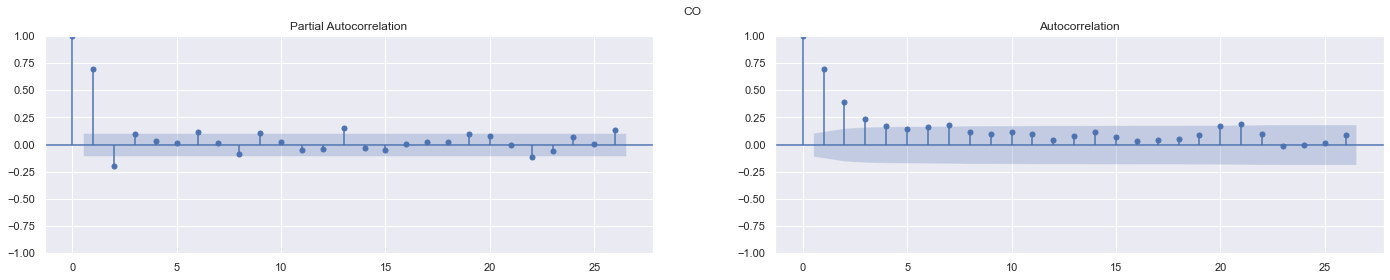

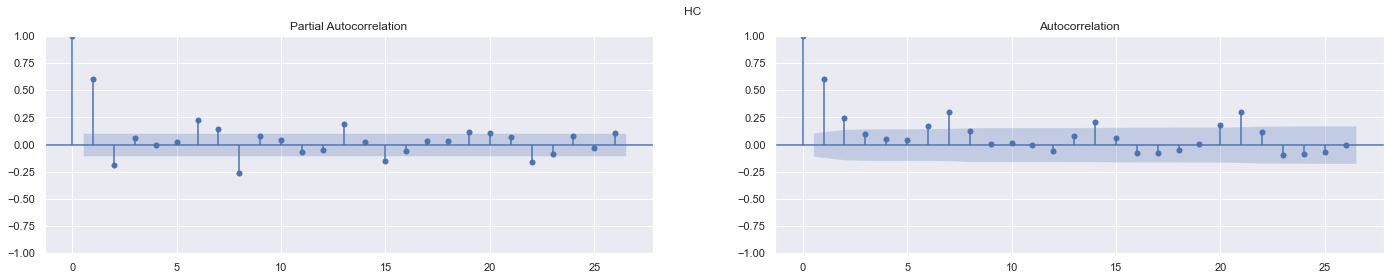

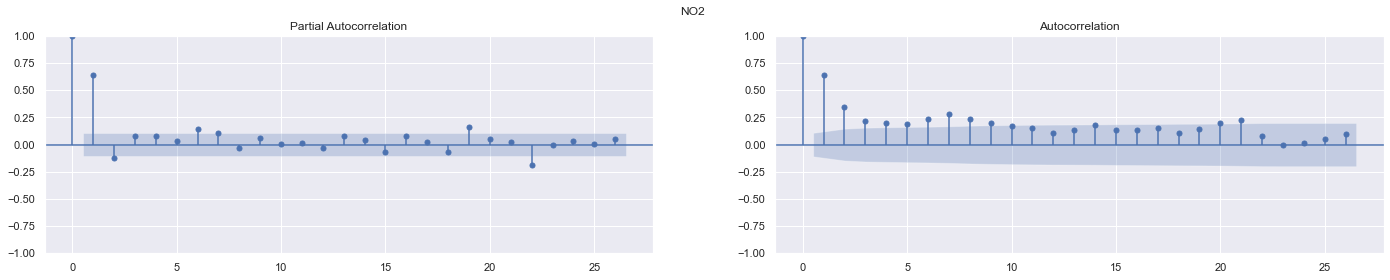

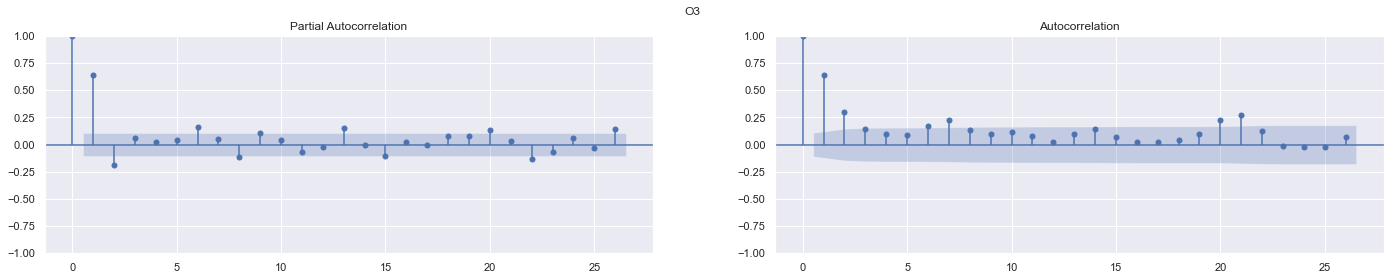

In [28]:
gases = ['CO', 'HC', 'NO2', 'O3']

for gas in gases:
    plot_pacf_acf(
        df_polate[gas],
        figtitle=gas,
    )

plt.show()

## PACF, AR
## All strong spike at 1, weaker spike at 2
## Some have more significant spikes further out like HC and O3, but separated by large gaps

## ACF, MA
## HC and O3 have more significant spikes up to 2
## CO has spikes up to 3 
## NO2 has spikes all the way up to 9, bends at 3
## The spikes seem to have a period of 7 for significance, maybe corresponding to weekly trend

From the decomposition and ACF plots, there is strong evidence for a weekly trend in the data, hence we will investigate the 7 $^{th}$ lags of our data

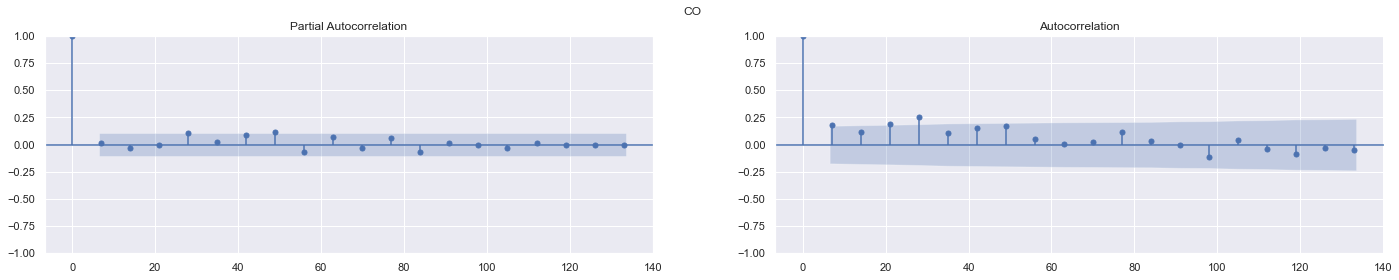

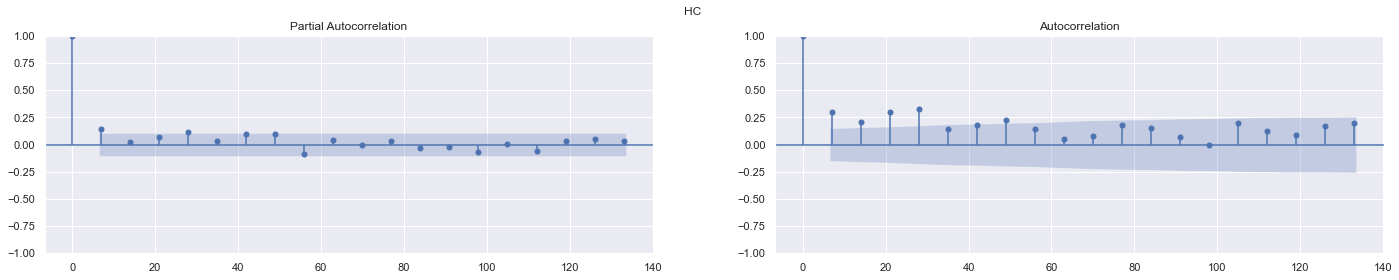

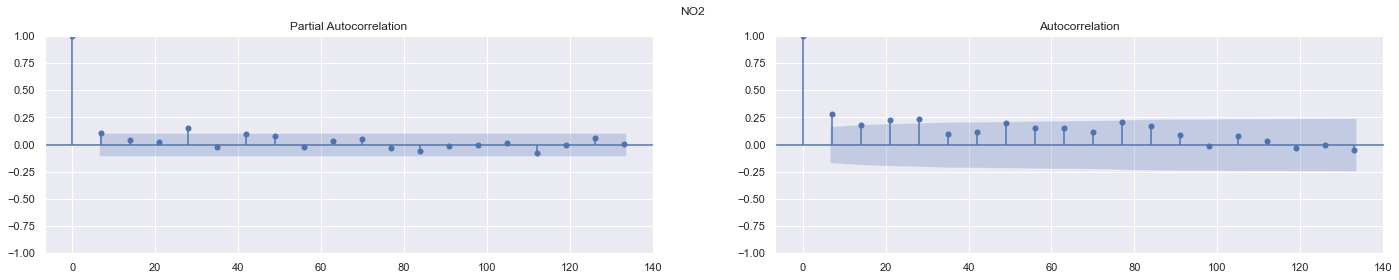

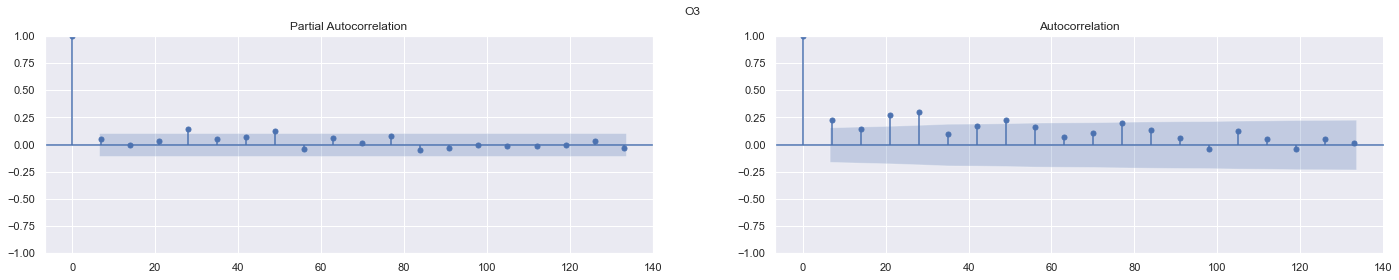

In [29]:
for gas in gases:
    plot_pacf_acf(
        df_polate[gas],
        figtitle=gas,
        lags=np.arange(0, 7 * 20, 7)
    )

plt.show()

## PACF, AR
## No strong significant spikes near the start, only weak spikes at 4 for all

## ACF, MA
## Significant spike up to 4, stronger spikes at 3 and 4 than 1 and 2 for all, weakest at 2
## CO has weaker spikes than others

# Modelling

## Functions and Libraries

In [30]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX



In [31]:
## Splits data using TimeSeriesSplit and performs cross-validation
# Returns .summary_frame() from all fitted models and final fitted model

from sklearn.model_selection import TimeSeriesSplit


def cross_validate_model(
    data,
    endog,
    model,
    model_kwargs,
    exog=None,
    validate_size=30,
    fit_kwargs=None,
    n_splits=6,
):
    if fit_kwargs is None:
        fit_kwargs = {}

    results_df = pd.DataFrame()

    for train_index, validate_index in TimeSeriesSplit(
        n_splits=n_splits, test_size=validate_size
    ).split(data):

        train = data.iloc[train_index]
        validate = data.iloc[validate_index]
        
        if exog is None:
            fit = model(train[endog], **model_kwargs).fit(**fit_kwargs)
            forecast_res = fit.get_forecast(len(validate_index))

        else:
            fit = model(train[endog], exog=train[exog], **model_kwargs).fit(**fit_kwargs)
            forecast_res = fit.get_forecast(
                steps=len(validate_index), exog=validate[exog]
            )

        summary_frame = forecast_res.summary_frame().loc[
            :, ["mean", "mean_ci_lower", "mean_ci_upper"]
        ]
        forecast_df = pd.DataFrame(
            summary_frame.values, index=validate.index, columns=summary_frame.columns
        )
        results_df = pd.concat([results_df, forecast_df], axis=0)

    return results_df, fit


In [32]:
## Evaluates results of predicted values
# Returns a plotly graph and rmse score

from statsmodels.tools.eval_measures import rmse


def evaluate_model(results_df, test, plot_CI=True):
    fig = go.Figure(layout={"title": test.name})

    fig.add_traces(
        data=[
            go.Scatter(
                x=test.index, y=test.values, name="Actual", line_color="green"
            ),
            go.Scatter(
                x=results_df.index,
                y=results_df["mean"],
                name="Predicted",
                line_color="black",
            ),
        ]
    )
    if plot_CI:
        fig.add_trace(
            go.Scatter(
                x=results_df.index.append(results_df.index[::-1]),
                y=pd.concat(
                    [
                        results_df["mean_ci_upper"],
                        results_df["mean_ci_lower"].iloc[::-1],
                    ],
                ),
                line_color='red',
                fillcolor="rgba(255, 0, 0, 0.1)",
                fill="toself",
                name="95% CI",
                hoverinfo="skip",
            ),
        )

    rmse_score = rmse(results_df["mean"], test[-len(results_df):])

    return fig, rmse_score


In [33]:
## Executes cross_validate_model() on the four different gas columns and evalutes using evaluate_models()
# Returns .summary_frame(), plotly graph and rmse

def cross_validate_models(
    df,
    features,
    model,
    exog=None,
    order=(0, 0, 0),
    seasonal_order=(0, 0, 0, 0),
    model_kwargs=None,
    fit_kwargs=None,
    cv_kwargs=None,
    eval_kwargs=None,
):
    fit_results = {}

    if model_kwargs is None:
        model_kwargs = {}
    if cv_kwargs is None:
        cv_kwargs = {}
    if eval_kwargs is None:
        eval_kwargs = {}

    for i, feat in enumerate(features):
        if isinstance(order, list):
            model_kwargs["order"] = order[i]
        else:
            model_kwargs["order"] = order

        if isinstance(seasonal_order, list):
            model_kwargs["seasonal_order"] = seasonal_order[i]
        else:
            model_kwargs["seasonal_order"] = seasonal_order

        # print(model_kwargs)

        results_df, cv_fit = cross_validate_model(df, feat, model, model_kwargs, exog, fit_kwargs=fit_kwargs, **cv_kwargs)
        fig, rmse = evaluate_model(results_df, df[feat], **eval_kwargs)

        fit_results[feat] = (results_df, fig, rmse, cv_fit)

    return fit_results


In [9]:
## Fits models for the four different gases and evaluates using evaluate_models()
# Returns model, a plotly graph and rmse


def fit_models(
    train,
    test,
    endogs,
    model,
    order=(0, 0, 0),
    seasonal_order=(0, 0, 0, 0),
    exog=None,
    model_kwargs=None,
    fit_kwargs=None,
):
    models = {}

    if model_kwargs is None:
        model_kwargs = {}

    if fit_kwargs is None:
        fit_kwargs = {}

    for i, feat in enumerate(endogs):
        if isinstance(order, list):
            model_kwargs["order"] = order[i]
        else:
            model_kwargs["order"] = order

        if isinstance(seasonal_order, list):
            model_kwargs["seasonal_order"] = seasonal_order[i]
        else:
            model_kwargs["seasonal_order"] = seasonal_order

                
        if exog is None:
            fit_model = model(train[feat], **model_kwargs).fit(**fit_kwargs)
            results_df = fit_model.get_forecast(len(test)).summary_frame()

        else:
            fit_model = model(train[feat], train[exog], **model_kwargs).fit(**fit_kwargs)
            results_df = fit_model.get_forecast(
                steps=len(test), exog=test[exog]
            ).summary_frame()

        fig, rmse = evaluate_model(results_df, test[feat])

        models[feat] = (fit_model, fig, rmse)

    return models


## ARIMA

From the ACF and PACF plots,

we found that the PACF and AR for all the gases had strong spikes at 1 and slightly significant spikes at 2,

and we found that the ACF and MA for 
- HC and O3 had two strong spikes, 
- 3 for CO and 
- 9 for NO2, but it flattens before 3 and increases afterwards

and all the gases showed periodic spikes at multiples of 7

In [32]:
order = [
    (1, 0, 3),
    (1, 0, 2),
    (1, 0, 2),
    (1, 0, 2),
]

arma_cv = cross_validate_models(
    df_polate,
    gases,
    ARIMA,
    order=order,
)

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [33]:
order = [
    (2, 0, 3),
    (2, 0, 2),
    (2, 0, 2),
    (2, 0, 2),
]

ar2ma_cv = cross_validate_models(
    df_polate,
    gases,
    ARIMA,
    order=order,
)

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\bevan\AppData\Roaming\Pytho

### Cross-Validation Results

#### AR(1)

In [34]:
for gas in gases:
    print(f"{gas} cv RMSE: {arma_cv[gas][2]}")

CO cv RMSE: 121.51059268345765
HC cv RMSE: 131.89298446935595
NO2 cv RMSE: 160.9206014626233
O3 cv RMSE: 241.74705504394544


In [35]:
print(arma_cv['CO'][3].summary())

## (1,0,3)
## ma.L1 has p=0.083
## AIC 3426.602
## BIC 3448.785

                               SARIMAX Results                                
Dep. Variable:                     CO   No. Observations:                  298
Model:                 ARIMA(1, 0, 3)   Log Likelihood               -1707.301
Date:                Thu, 11 Aug 2022   AIC                           3426.602
Time:                        19:53:04   BIC                           3448.785
Sample:                    03-15-2016   HQIC                          3435.482
                         - 01-06-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        876.2009     31.953     27.422      0.000     813.574     938.828
ar.L1          0.9739      0.027     35.779      0.000       0.921       1.027
ma.L1         -0.1177      0.068     -1.731      0.0

In [36]:
print(arma_cv['HC'][3].summary())

## (1,0,2)
## ar.L1 has p=0.306
## AIC 3511.795
## BIC 3530.281

                               SARIMAX Results                                
Dep. Variable:                     HC   No. Observations:                  298
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1750.898
Date:                Thu, 11 Aug 2022   AIC                           3511.795
Time:                        19:53:04   BIC                           3530.281
Sample:                    03-15-2016   HQIC                          3519.195
                         - 01-06-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        766.8472     10.261     74.734      0.000     746.736     786.958
ar.L1         -0.1534      0.150     -1.024      0.306      -0.447       0.140
ma.L1          0.8965      0.134      6.686      0.0

In [37]:
print(arma_cv['NO2'][3].summary())

## (1,0,2)
## ma.L1 has p=0.164
## ma.L2 has p=0.759
# AIC 3622.085
# BIC 3640.570

                               SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                  298
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1806.042
Date:                Thu, 11 Aug 2022   AIC                           3622.085
Time:                        19:53:04   BIC                           3640.570
Sample:                    03-15-2016   HQIC                          3629.484
                         - 01-06-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        685.4173     18.278     37.500      0.000     649.594     721.241
ar.L1          0.4567      0.182      2.508      0.012       0.100       0.814
ma.L1          0.2653      0.191      1.392      0.1

In [38]:
print(arma_cv['O3'][3].summary())

## (1,0,2)  
## ar.L1 has p=0.298
## AIC 3830.501
## BIC 3848.986

                               SARIMAX Results                                
Dep. Variable:                     O3   No. Observations:                  298
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -1910.251
Date:                Thu, 11 Aug 2022   AIC                           3830.501
Time:                        19:53:04   BIC                           3848.986
Sample:                    03-15-2016   HQIC                          3837.901
                         - 01-06-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        808.9842     20.000     40.448      0.000     769.784     848.184
ar.L1          0.1427      0.137      1.040      0.298      -0.126       0.412
ma.L1          0.6733      0.133      5.048      0.0

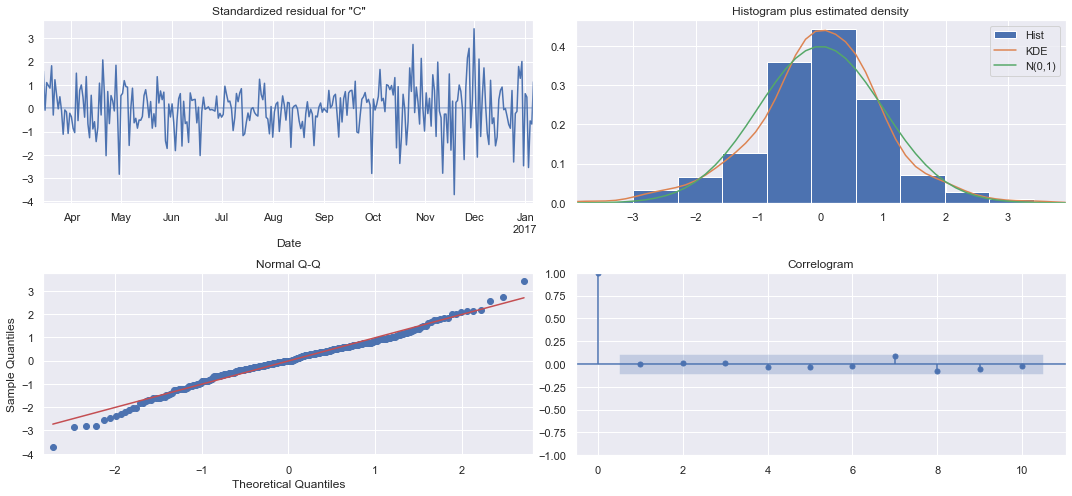

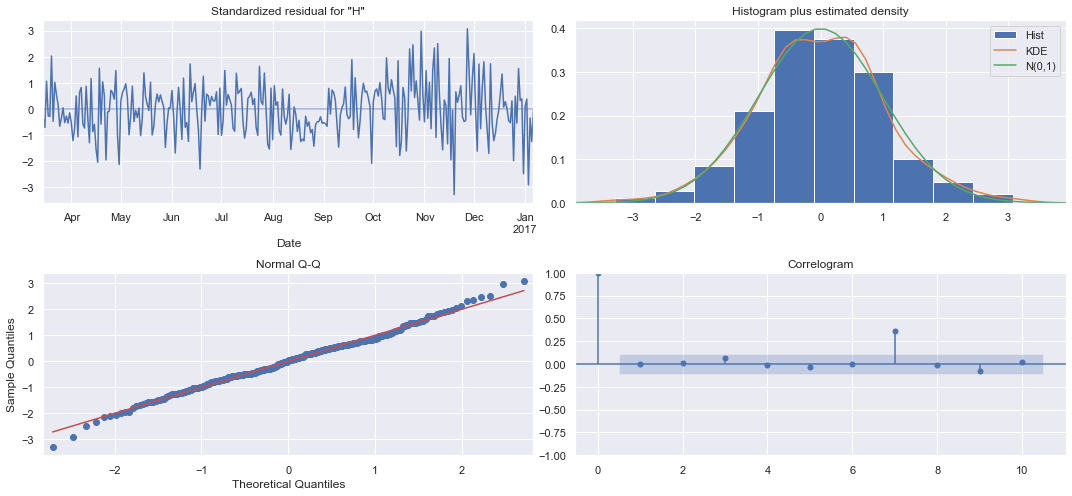

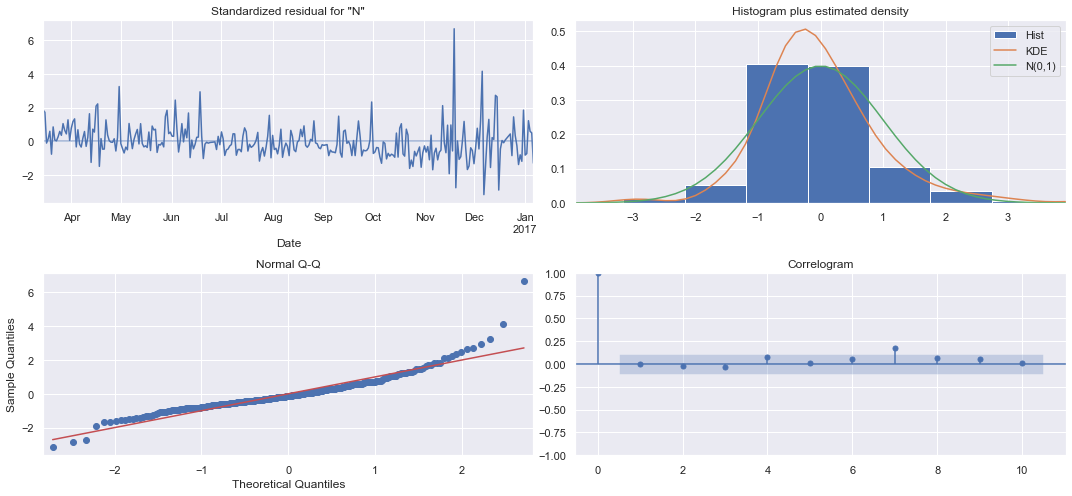

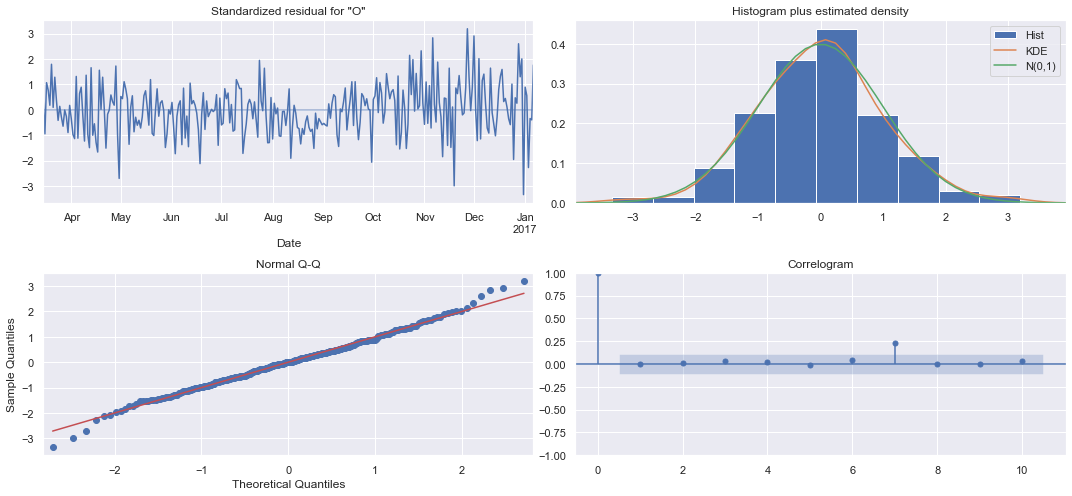

In [39]:
for gas in gases:
    arma_cv[gas][3].plot_diagnostics().set_size_inches(15, 7)

    plt.tight_layout()
    plt.show()
    
## N has slight negative skew for , std. also increases for later values midway into Nov
## The other residuals are quite normally distributed
# spike at 7 for CO is not quite as significant as the others 

#### AR(2)

In [40]:
for gas in gases:
    print(f"{gas} cv RMSE: {ar2ma_cv[gas][2]}")

CO cv RMSE: 121.15925398668554
HC cv RMSE: 133.67597605455424
NO2 cv RMSE: 160.19575105713662
O3 cv RMSE: 238.2470987570719


In [41]:
print(ar2ma_cv['CO'][3].summary())

## (2,0,3)
## ar.L2 has p=0.589
## ma.L1 has p=0.241
## AIC 3428.398
## BIC 3454.277

                               SARIMAX Results                                
Dep. Variable:                     CO   No. Observations:                  298
Model:                 ARIMA(2, 0, 3)   Log Likelihood               -1707.199
Date:                Thu, 11 Aug 2022   AIC                           3428.398
Time:                        19:53:14   BIC                           3454.277
Sample:                    03-15-2016   HQIC                          3438.757
                         - 01-06-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        876.2459     32.500     26.962      0.000     812.548     939.944
ar.L1          1.0714      0.181      5.911      0.000       0.716       1.427
ar.L2         -0.0933      0.173     -0.540      0.5

In [42]:
print(ar2ma_cv['HC'][3].summary())

## (2,0,2)
## ar.L1 has p=0.489
## ar.L2 has p=0.996
## AIC 3513.795
## BIC 3522.675

                               SARIMAX Results                                
Dep. Variable:                     HC   No. Observations:                  298
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1750.898
Date:                Thu, 11 Aug 2022   AIC                           3513.795
Time:                        19:53:14   BIC                           3535.978
Sample:                    03-15-2016   HQIC                          3522.675
                         - 01-06-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        766.8472     10.267     74.687      0.000     746.723     786.971
ar.L1         -0.1532      0.222     -0.692      0.489      -0.588       0.281
ar.L2          0.0008      0.147      0.005      0.9

In [43]:
print(ar2ma_cv['NO2'][3].summary())

## (2,0,2)
## ar.L1 has p=0.917
## ar.L2 has p=0.581
## ma.L1 has p=0.258
## ma.L2 has p=0.136
# AIC 3623.285
# BIC 3645.468

                               SARIMAX Results                                
Dep. Variable:                    NO2   No. Observations:                  298
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1805.643
Date:                Thu, 11 Aug 2022   AIC                           3623.285
Time:                        19:53:14   BIC                           3645.468
Sample:                    03-15-2016   HQIC                          3632.165
                         - 01-06-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        685.4467     17.882     38.332      0.000     650.399     720.495
ar.L1         -0.0735      0.704     -0.104      0.917      -1.453       1.306
ar.L2          0.2219      0.402      0.553      0.5

In [44]:
print(ar2ma_cv['O3'][3].summary())

## (2,0,2)  
## ar.L1 has p=0.970
## ar.L2 has p=0.554
## AIC 3831.832
## BIC 3854.712

                               SARIMAX Results                                
Dep. Variable:                     O3   No. Observations:                  298
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1909.916
Date:                Thu, 11 Aug 2022   AIC                           3831.832
Time:                        19:53:14   BIC                           3854.015
Sample:                    03-15-2016   HQIC                          3840.712
                         - 01-06-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        808.9823     20.810     38.875      0.000     768.196     849.769
ar.L1         -0.0110      0.289     -0.038      0.970      -0.578       0.556
ar.L2          0.1048      0.177      0.592      0.5

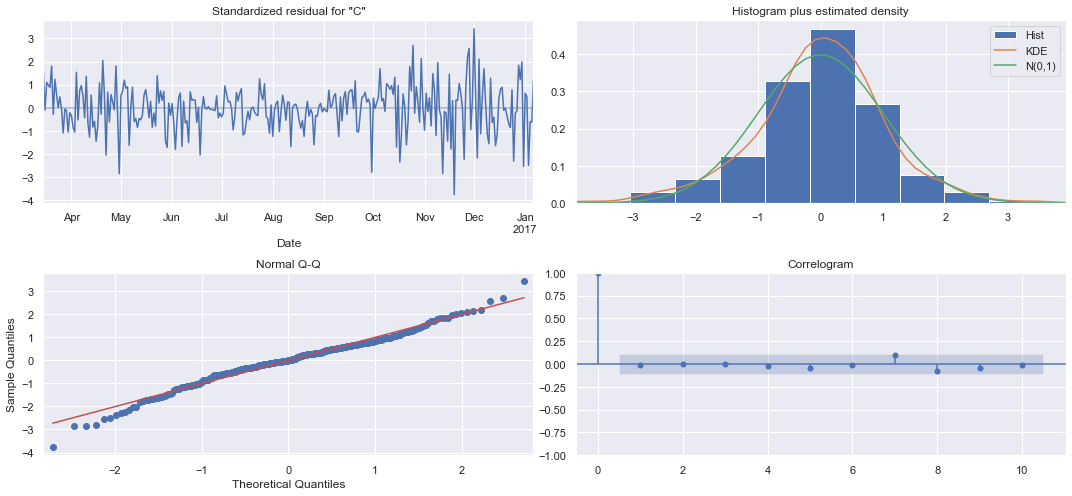

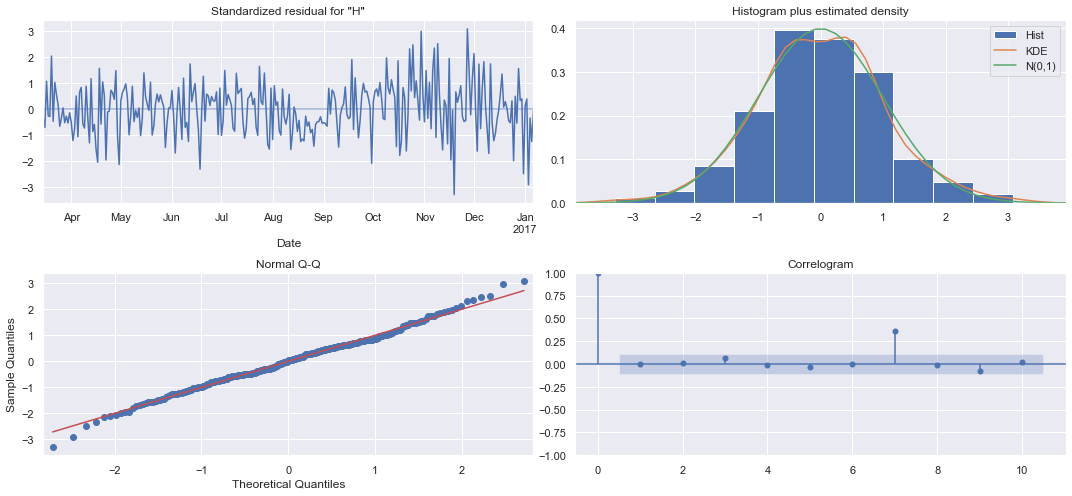

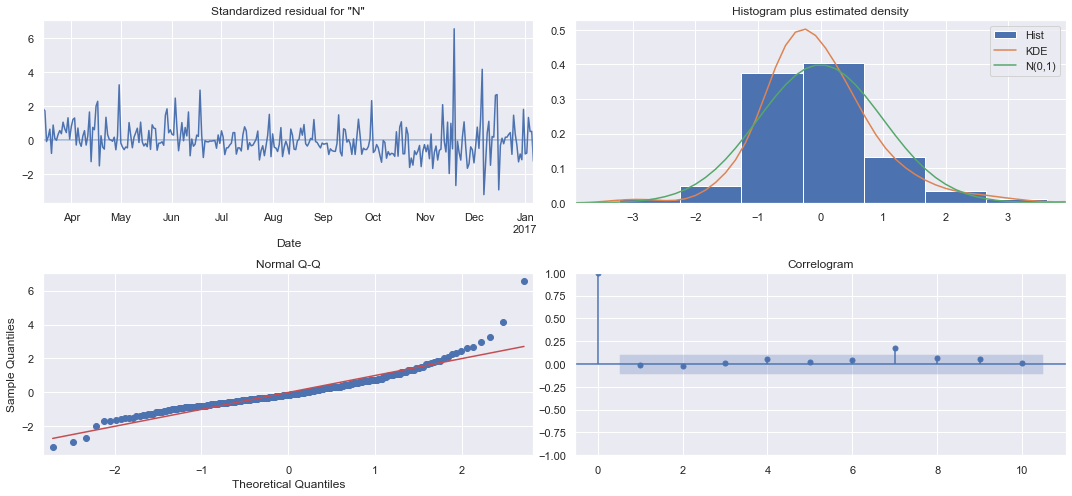

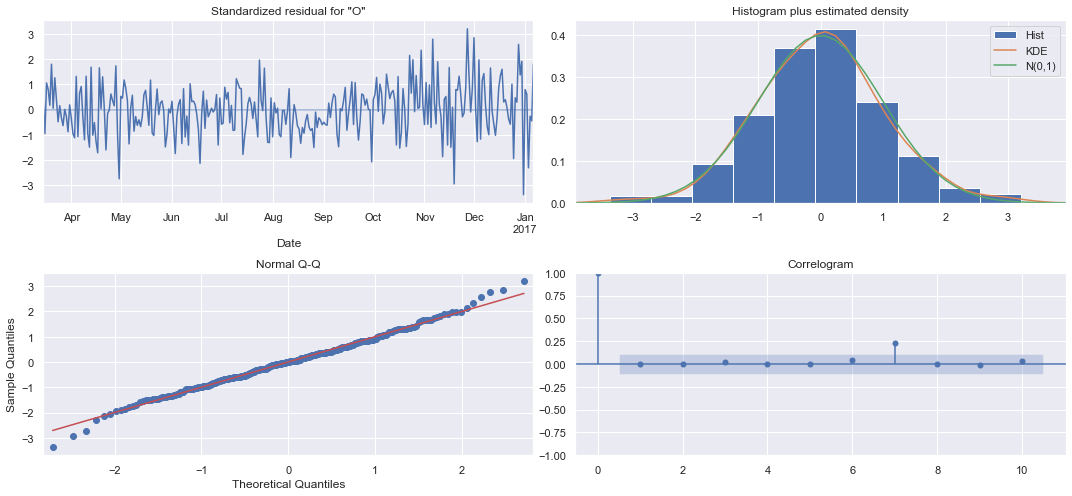

In [45]:
for gas in gases:
    ar2ma_cv[gas][3].plot_diagnostics().set_size_inches(15, 7)

    plt.tight_layout()
    plt.show()

## N has slight negative skew for , std. also increases for later values midway into Nov
## The other residuals are quite normally distributed
## All have a significant ACF spike at 7, suggesting the weekly trend once again
# spike at 7 for CO is once again not quite as significant as the others 

#### Predict Plots

Although the AR(2) models had slightly better RMSE scores, the residual diagnostics show that they don't succeed in reducing the residuals by any significant amount, \
In addition, the AIC and BIC scores for the AR(2) models were worse than the AR(1) models and HC actually performed worse \
A notable exception would be O3 where its AR(2) process performed better both with a smaller RMSE and BIC scores

Hence, the AR(1)MA(Q) process is used for further evaluation and AR(2)MA(Q) for O3

In [46]:
arma_cv['CO'][1]

In [47]:
arma_cv['HC'][1]

In [48]:
arma_cv['NO2'][1]

In [49]:
arma_cv['O3'][1]

The Predicted vs. Actual plots all show that the ARMA models all succeeded in prediciting values that seem quite close to the means of the actual data within the 30-day test intervals. \
However, none managed to capture the periodic spikes of the actual data, which is to be expected from a model that does not consider seasonal trends

## SARIMA

From the ACF and PACF plots at periods of 7,

we found that the PACF and AR spikes for all the gases had no significance at all,

and we found that the ACF and MA for all the gases had significant spikes up to 4, with weaker spikes at 1 and weakest at 2 \
notably, CO had weaker spikes than the others


In [50]:
sarma_cv = cross_validate_models(
    df_polate,
    gases,
    SARIMAX,
    order=order,
    seasonal_order=(0, 0, 4, 7),
)


C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\bevan\AppData\R

### Cross-Validated Results

In [51]:
for gas in gases:
    print(f"{gas} cv RMSE: {sarma_cv[gas][2]}")

CO cv RMSE: 121.03800706059694
HC cv RMSE: 425.27343039755834
NO2 cv RMSE: 159.551840978718
O3 cv RMSE: 245.7426110400165


In [52]:
print(sarma_cv['CO'][3].summary())

## (1,0,3) X (0, 0, 4, 7)
## ar.L2 has p=0.344
## ma.S.L7 has p=0.331
## ma.S.L14 has p=0.670
## ma.S.L21 has p=0.215
## AIC 3425.997
## BIC 3463.251

                                          SARIMAX Results                                           
Dep. Variable:                                           CO   No. Observations:                  298
Model:             SARIMAX(2, 0, 3)x(0, 0, [1, 2, 3, 4], 7)   Log Likelihood               -1703.314
Date:                                      Thu, 11 Aug 2022   AIC                           3426.627
Time:                                              19:56:23   BIC                           3463.598
Sample:                                          03-15-2016   HQIC                          3441.426
                                               - 01-06-2017                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2123      0.161  

In [53]:
print(sarma_cv['HC'][3].summary())

## (1,0,2) X (0, 0, 4, 7)
## ma.S.L14 has p=0.041
## AIC 3495.313
## BIC 3505.890

                                          SARIMAX Results                                           
Dep. Variable:                                           HC   No. Observations:                  298
Model:             SARIMAX(2, 0, 2)x(0, 0, [1, 2, 3, 4], 7)   Log Likelihood               -1726.121
Date:                                      Thu, 11 Aug 2022   AIC                           3470.241
Time:                                              19:56:23   BIC                           3503.515
Sample:                                          03-15-2016   HQIC                          3483.560
                                               - 01-06-2017                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5156      0.087  

In [54]:
print(sarma_cv['NO2'][3].summary())

## (1,0,2) X (0, 0, 4, 7)
## ma.S.L7 has p=0.228
## ma.S.L14 has p=0.761
## ma.S.L21 has p=0.060
## ma.S.L28 has p=0.147
## AIC 3615.7618
## BIC 3645.338

                                          SARIMAX Results                                           
Dep. Variable:                                          NO2   No. Observations:                  298
Model:             SARIMAX(2, 0, 2)x(0, 0, [1, 2, 3, 4], 7)   Log Likelihood               -1796.307
Date:                                      Thu, 11 Aug 2022   AIC                           3610.615
Time:                                              19:56:23   BIC                           3643.889
Sample:                                          03-15-2016   HQIC                          3623.934
                                               - 01-06-2017                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3774      0.121  

In [55]:
print(sarma_cv['O3'][3].summary())

## (1,0,2) X (0, 0, 4, 7)
# ar.L2 hasp=0.844
# ma.L2 has p=0.647
## ma.S.L14 has p=0.641
## AIC 3876.906
## BIC 3899.168

                                          SARIMAX Results                                           
Dep. Variable:                                           O3   No. Observations:                  298
Model:             SARIMAX(2, 0, 2)x(0, 0, [1, 2, 3, 4], 7)   Log Likelihood               -1928.694
Date:                                      Thu, 11 Aug 2022   AIC                           3875.387
Time:                                              19:56:23   BIC                           3908.661
Sample:                                          03-15-2016   HQIC                          3888.706
                                               - 01-06-2017                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0177      0.090  

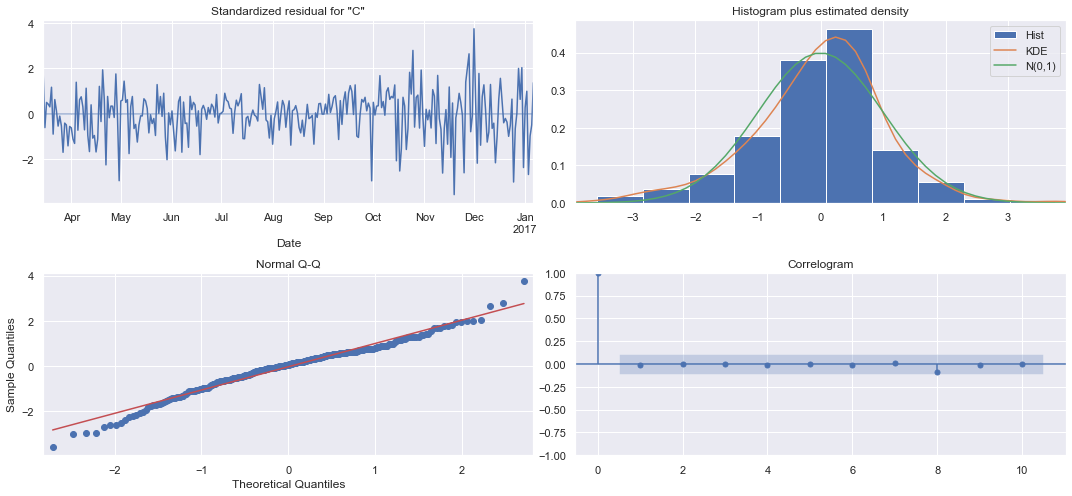

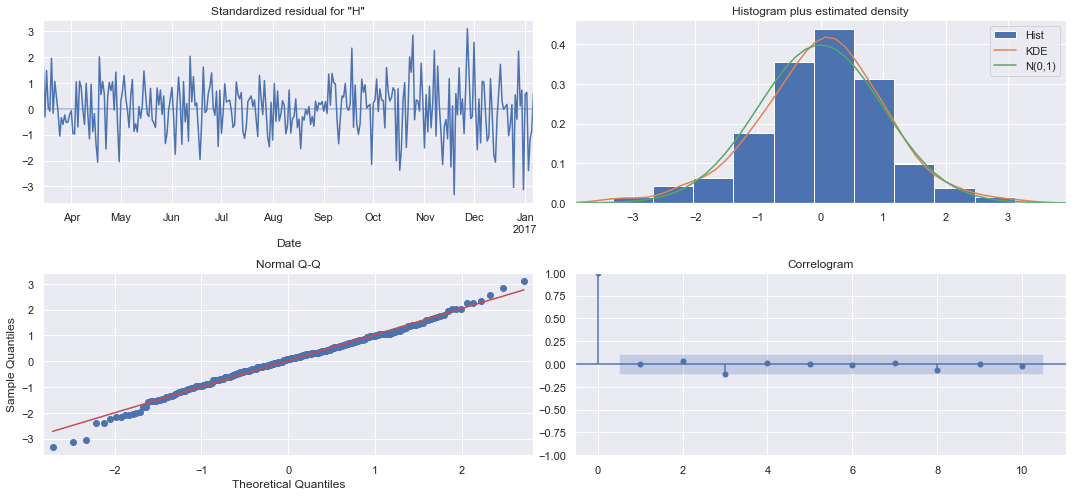

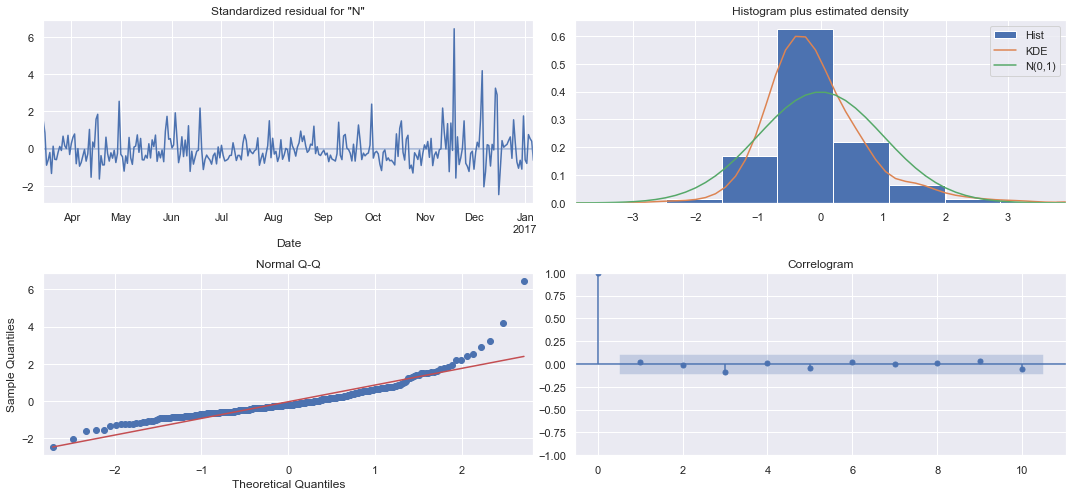

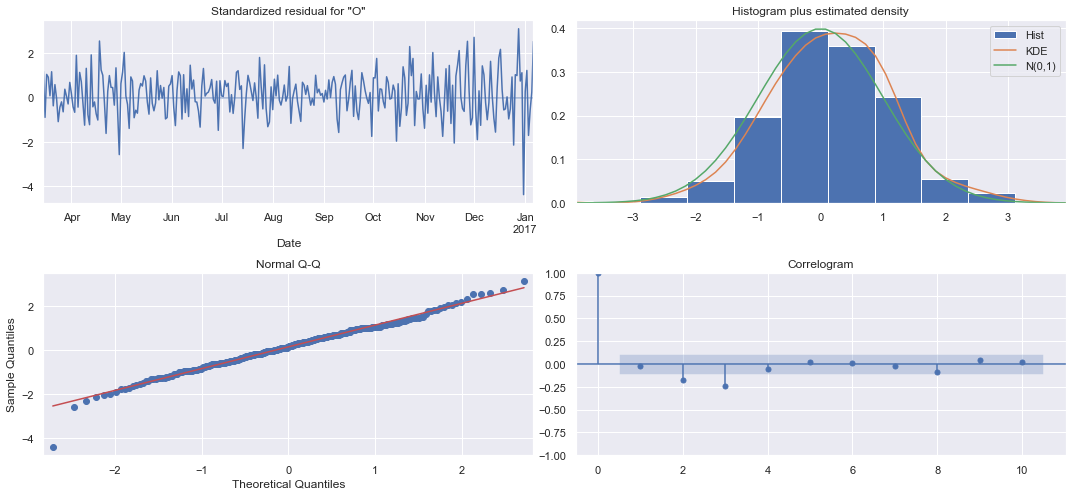

In [56]:
for gas in gases:
    sarma_cv[gas][3].plot_diagnostics().set_size_inches(15, 7)

    plt.tight_layout()
    plt.show()

## N has slight negative skew for , std. also increases for later values midway into Nov
## The other residuals are quite normally distributed
## The ACF spike at 7 has disappeared for all the gases, however, significant spikes have appeared at 1 and 2 

#### Plots

In [57]:
sarma_cv['CO'][1]

The SARIMA model for CO seems to have barely captured the seasonality changes of the actual data within the testing intervals, with the Predicted curve mirroring the changes of the Actual curve at a few locations. \
Notably,
- the rise and fall from 20 Aug to 27 Aug
- the spike from 28 Dec to 31 Dec 

However, these matches are so few and far between that we can't say the model performs well, and the model misses quite a few of the significant spikes 

In [58]:
sarma_cv['HC'][1]

The SARMA model for HC has a jarringly inaccurate forecast from Oct 8 to Nov 8 where its forecast is far lower than the actual values, guessing values far into the negative range. \
Aside from this, the rest of the forecasts also seem to not match the seasonal fluctuations of the actual data very well, once again matching up occasionally but failing to match the actual data overall.

In [59]:
## Double check predictions for Oct 8 to Nov 8
#
# HC_check_test = df_polate.loc["2016-10-8":"2016-11-8"]
# HC_check_train = df_polate.loc[:"2016-10-8"]

# model, fig, rmse = fit_models(
#     train=HC_check_train,
#     test=HC_check_test,
#     endogs=["HC"],
#     model=SARIMAX,
#     seasonal_order=(0, 0, 4, 7),
#     order=order[1],
# )

# res['HC'][1]


In [60]:
sarma_cv['NO2'][1]

Similar to before, the model doesn't succeed in capturing the fluctuations very well and the confidence interval for the second last test period is significantly larger than the others. \
Interestingly, it still matches the initial forecast quite well

In [61]:
sarma_cv['O3'][1]

The model still doesn't capture the fluctuations, and the initial forecast doesn't seem quite as accurate 

Overall, the SAR(0)MA(4) process stills fail to model the Actual data successfully and don't perform any more significantly better than the ARMA models, with HC and CO even performing worse. 

### (1, 0, 4) Seasonal

From the residual plots of the MA(4), an point of interest was that although the significant spike at lag 7 of the ARMA models had disappeared, spikes at 1 and 2 had appeared in its place, suggesting that the model was failnig to capture some simple correlations.\
If this is the case, perhaps adding an additional seasonal AR(1) would be able to capture the missing information  

In [62]:
sar1ma_cv = cross_validate_models(
    df_polate,
    gases,
    SARIMAX,
    order=order,
    seasonal_order=(1, 0, 4, 7),
)


C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning:

Non-stationary starting seasonal autoregressive Using zeros as starting parameters.

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bevan\AppData\Roaming\Python\Python3

#### Results

In [63]:
for gas in gases:
    print(f"{gas} cv RMSE: {sar1ma_cv[gas][2]}")

CO cv RMSE: 122.47761062465389
HC cv RMSE: 131.65602667250033
NO2 cv RMSE: 150.64751254162252
O3 cv RMSE: 227.009610598643


In [64]:
print(sar1ma_cv['CO'][3].summary())

## (1,0,3) X (1, 0, 4, 7)
## ar.L2 has p =0.179
## ma.S.L14 has p=0.789
## ma.S.L21 has p=0.295
## ma.S.L28 has p=0.845
## AIC 3414.910
## BIC 3453.881

                                          SARIMAX Results                                           
Dep. Variable:                                           CO   No. Observations:                  298
Model:             SARIMAX(2, 0, 3)x(1, 0, [1, 2, 3, 4], 7)   Log Likelihood               -1696.899
Date:                                      Thu, 11 Aug 2022   AIC                           3415.798
Time:                                              19:59:47   BIC                           3456.466
Sample:                                          03-15-2016   HQIC                          3432.077
                                               - 01-06-2017                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2236      0.169  

In [65]:
print(sar1ma_cv['HC'][3].summary())

## (1,0,2) X (1, 0, 4, 7)
## ma.L2 has p=0.229
## ma.S.L14 has p=0.789
## ma.S.L21 has p=0.295
## ma.S.L28 has p=0.845
## AIC 3447.814
## BIC 3481.088

                                          SARIMAX Results                                           
Dep. Variable:                                           HC   No. Observations:                  298
Model:             SARIMAX(2, 0, 2)x(1, 0, [1, 2, 3, 4], 7)   Log Likelihood               -1715.290
Date:                                      Thu, 11 Aug 2022   AIC                           3450.580
Time:                                              19:59:47   BIC                           3487.551
Sample:                                          03-15-2016   HQIC                          3465.379
                                               - 01-06-2017                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3079      0.199  

In [66]:
print(sar1ma_cv['NO2'][3].summary())

## (1,0,2) X (1, 0, 4, 7)
## ma.S.L14 has p=0.780
## ma.S.L21 has p=0.103
## ma.S.L28 has p=0.403
## AIC 3608.126
## BIC 3641.400

                                          SARIMAX Results                                           
Dep. Variable:                                          NO2   No. Observations:                  298
Model:             SARIMAX(2, 0, 2)x(1, 0, [1, 2, 3, 4], 7)   Log Likelihood               -1789.361
Date:                                      Thu, 11 Aug 2022   AIC                           3598.721
Time:                                              19:59:48   BIC                           3635.692
Sample:                                          03-15-2016   HQIC                          3613.520
                                               - 01-06-2017                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4320      0.104  

In [67]:
print(sar1ma_cv['O3'][3].summary())

## (1,0,2) X (1, 0, 4, 7)
## ma.S.L14 has p=0.506
## ma.S.L21 has p=0.266
## ma.S.L28 has p=0.742
## AIC 3813.640
## BIC 3846.914

                                          SARIMAX Results                                           
Dep. Variable:                                           O3   No. Observations:                  298
Model:             SARIMAX(2, 0, 2)x(1, 0, [1, 2, 3, 4], 7)   Log Likelihood               -1899.758
Date:                                      Thu, 11 Aug 2022   AIC                           3819.517
Time:                                              19:59:48   BIC                           3856.488
Sample:                                          03-15-2016   HQIC                          3834.316
                                               - 01-06-2017                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3517      0.094  

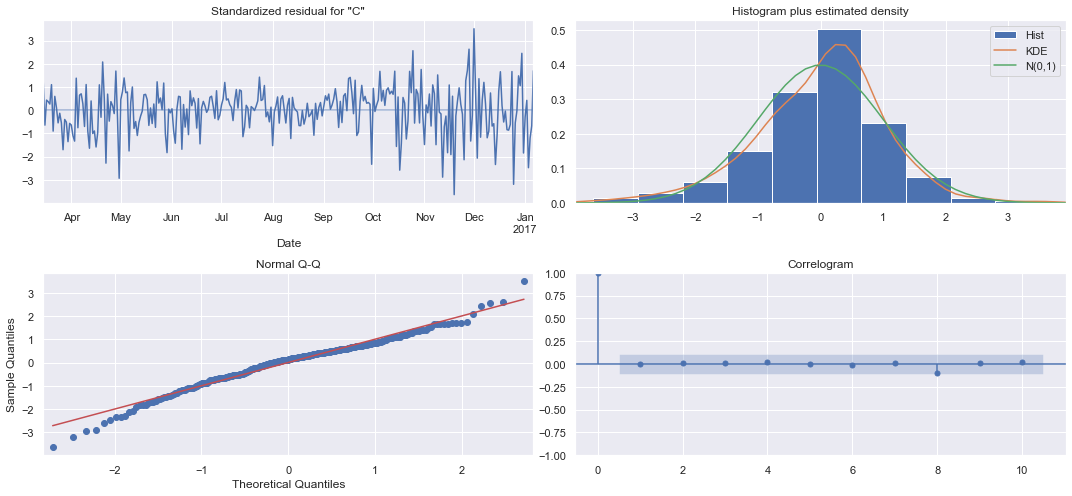

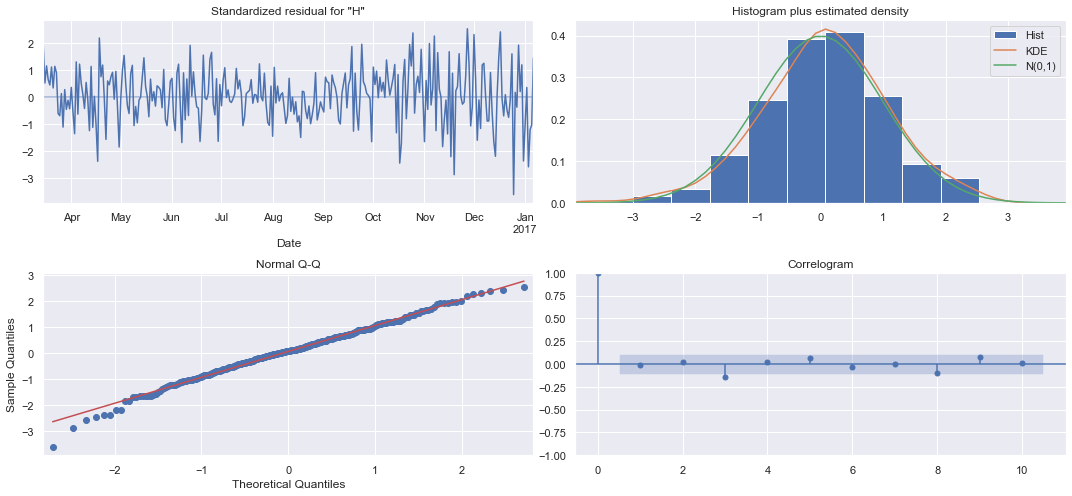

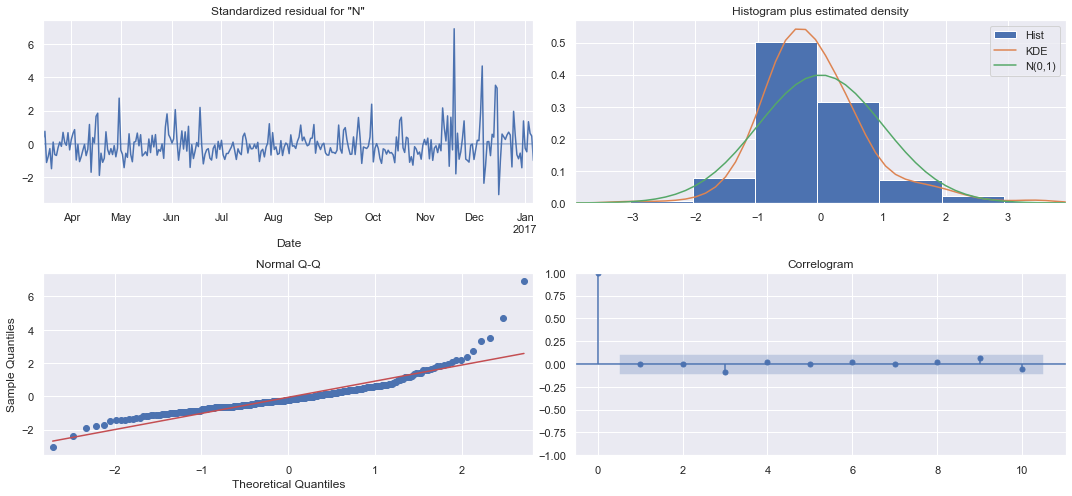

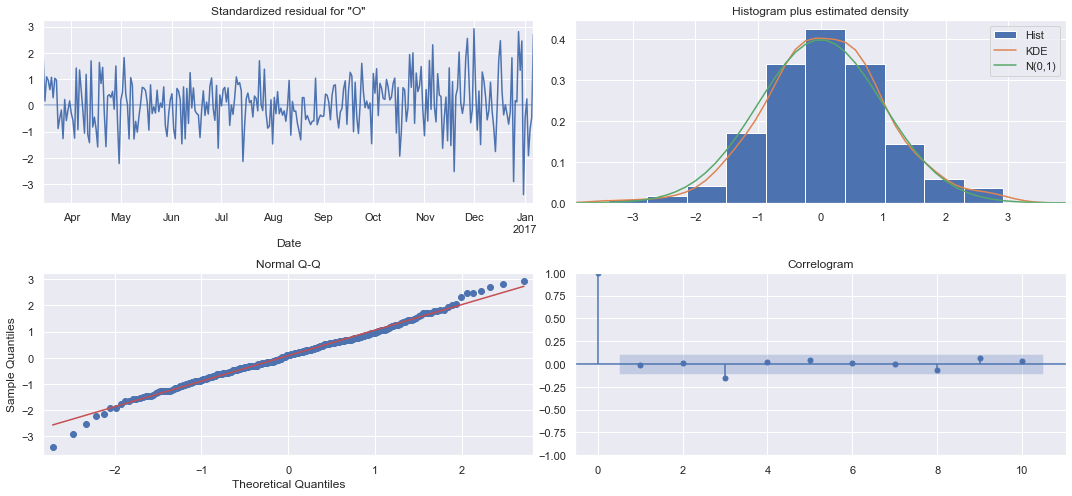

In [68]:
for gas in gases:
    sar1ma_cv[gas][3].plot_diagnostics().set_size_inches(15, 7)

    plt.tight_layout()
    plt.show()

## N has slight negative skew for , std. also increases for later values midway into Nov
## The other residuals are quite normally distributed
## The significant spike at 2 has mostly disappeared for all the gases 

#### Plots

In [69]:
sar1ma_cv['CO'][1]

In [70]:
sar1ma_cv['HC'][1]

In [71]:
sar1ma_cv['NO2'][1]

In [72]:
sar1ma_cv['O3'][1]

With additional seasonal AR(1), all of the Predicted values now all mirror the actual plots much more closely and seem to capture the wekkly fluctuations quite successfully now. \
The RMSE and AIC & BIC scores for the seasonal AR(1)MA(4) have also all improved from the seasonal MA(4) model.

In [73]:
seasonal_order = (1, 0, 4, 7)

## SARIMAX

In [74]:
sarmax_cv = cross_validate_models(
    df_polate,
    gases,
    SARIMAX,
    exog=['T', 'RH'],
    order=order,
    seasonal_order=seasonal_order
)

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\mo

### Cross-Validate Results

In [75]:
for gas in gases:
    print(f"{gas} cv RMSE: {sarmax_cv[gas][2]}")

CO cv RMSE: 112.87962738949244
HC cv RMSE: 123.43922646866011
NO2 cv RMSE: 169.11387768813088
O3 cv RMSE: 239.4905098050879


In [76]:
print(sarmax_cv['CO'][3].summary())

## (1,0,3) X (1, 0, 4, 7)
## ma.S.L14 has p=0.667
## ma.S.L21 has p=0.017
## ma.S.L28 has p=0.568
## AIC 3351.910
## BIC 3395.881

                                          SARIMAX Results                                           
Dep. Variable:                                           CO   No. Observations:                  298
Model:             SARIMAX(2, 0, 3)x(1, 0, [1, 2, 3, 4], 7)   Log Likelihood               -1661.091
Date:                                      Thu, 11 Aug 2022   AIC                           3348.183
Time:                                              20:03:42   BIC                           3396.245
Sample:                                          03-15-2016   HQIC                          3367.421
                                               - 01-06-2017                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              8.5406      1.400  

In [77]:
print(sarmax_cv['HC'][3].summary())

## (1,0,3) X (1, 0, 4, 7)
## ma.S.L14 has p=0.257
## ma.S.L21 has p=0.084
## ma.S.L38 has p=0.237
## AIC 3442.943
## BIC 3483.611

                                          SARIMAX Results                                           
Dep. Variable:                                           HC   No. Observations:                  298
Model:             SARIMAX(2, 0, 2)x(1, 0, [1, 2, 3, 4], 7)   Log Likelihood               -1698.552
Date:                                      Thu, 11 Aug 2022   AIC                           3421.105
Time:                                              20:03:42   BIC                           3465.470
Sample:                                          03-15-2016   HQIC                          3438.864
                                               - 01-06-2017                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T              7.9752      1.478  

In [78]:
print(sarmax_cv['NO2'][3].summary())

## (1,0,3) X (1, 0, 4, 7)
## ma.S.L14 has p=0.447
## ma.S.L21 has p=0.264
## ma.S.L38 has p=0.409
## AIC 3605.332
## BIC 3646.611

                                          SARIMAX Results                                           
Dep. Variable:                                          NO2   No. Observations:                  298
Model:             SARIMAX(2, 0, 2)x(1, 0, [1, 2, 3, 4], 7)   Log Likelihood               -1785.579
Date:                                      Thu, 11 Aug 2022   AIC                           3595.158
Time:                                              20:03:42   BIC                           3639.523
Sample:                                          03-15-2016   HQIC                          3612.917
                                               - 01-06-2017                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T            -17.1379      2.213  

In [79]:
print(sarmax_cv['O3'][3].summary())

## (1,0,3) X (1, 0, 4, 7)
## ma.L1 has =0.087
## ma.l2 has p=0.177
## ma.S.L7 has p=0.506
## ma.S.L21 has p=0.266
## ma.S.L38 has p=0.151
## AIC 3803.921
## BIC 3843.921

                                          SARIMAX Results                                           
Dep. Variable:                                           O3   No. Observations:                  298
Model:             SARIMAX(2, 0, 2)x(1, 0, [1, 2, 3, 4], 7)   Log Likelihood               -1884.232
Date:                                      Thu, 11 Aug 2022   AIC                           3792.464
Time:                                              20:03:42   BIC                           3836.829
Sample:                                          03-15-2016   HQIC                          3810.223
                                               - 01-06-2017                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             10.7979      2.781  

#### Plots

In [80]:
sarmax_cv['CO'][1]

In [81]:
sarmax_cv['HC'][1]

In [82]:
sarmax_cv['NO2'][1]

In [83]:
sarmax_cv['O3'][1]

The SARIMAX models all seemed to greatly improve on the SARIMA models matching the fluctutations in the Actual curves much more closely than they previously did, with the exception of the O3 model having a slightly worse RMSE score 

# Kaggle Submission

## Functions and Libraries

In [2]:
## creates dict of possible combination tuples of specified order params
# e.g. {
# orers= [(p, d, q), (p, d, q), ...],
# seasonal orders = [(P, D, Q, M), (P, D, Q, M), ...]
# }
def create_orders_grid(
    p_start=0,
    p_end=4,
    q_start=0,
    q_end=4,
    d_start=0,
    d_end=2,
    P_start=0,
    P_end=4,
    Q_start=0,
    Q_end=4,
    D_start=0,
    D_end=2,
    S_start=7,
    S_end=7,
):
    order_grid = [
        (p, d, q)
        for p in range(p_start, p_end + 1)
        for d in range(d_start, d_end + 1)
        for q in range(q_start, q_end + 1)
    ]
    seasonal_order_grid = [
        (P, D, Q, S)
        for P in range(P_start, P_end + 1)
        for D in range(D_start, D_end + 1)
        for Q in range(Q_start, Q_end + 1)
        for S in range(S_start, S_end + 1)
    ]

    return {"order": order_grid, "seasonal_order": seasonal_order_grid}


In [1]:
## Runs a parameter tune using cross_validate_model() with a specified param_grid

from sklearn.model_selection import ParameterGrid

import warnings
from tqdm.notebook import tqdm

def parameter_tune(df, endog, model, param_grid, exog=None, cv_kwargs=None, fit_kwargs=None):
    if cv_kwargs is None:
        cv_kwargs = {}

    param_grid = ParameterGrid(param_grid)
    no_of_models = len(param_grid)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        flag = True

        for param_set, i in zip(param_grid, tqdm(range(no_of_models))):
            CVresults_df, cv_fit = cross_validate_model(
                df, endog, exog=exog, model=model, model_kwargs=param_set, fit_kwargs=fit_kwargs, **cv_kwargs
            )
            cv_rmse = rmse(CVresults_df['mean'], df[endog].iloc[-len(CVresults_df) :])

            if flag:
                best_params = param_set
                best_rmse = cv_rmse
                best_model = cv_fit
                flag = False

            if cv_rmse < best_rmse: 
                best_params = param_set
                best_rmse = cv_rmse
                best_model = cv_fit
            
        if best_rmse == 0:
            best_params = param_set
            best_model = cv_fit
        

    return best_rmse, best_params, best_model


## Tuning

From the exploratory modelling, the results for the best models for each gas is
- CO: SARIMAX(1, 0, 3)(1, 0, 4, 7), RMSE=112.9, AIC=3351.6, BIC=3395.4
- HC: SARIMAX(1, 0, 2)(1, 0, 4, 7), RMSE=123.1, AIC=3442.9, BIC=3483.6
- NO2: SARIMAX(1, 0, 2)(1, 0, 4, 7), RMSE=160.6, AIC=3605.3, BIC=3646.0
- O3: SARIMA(1, 0, 2)(1, 0, 4, 7), RMSE=216.4, AIC=3813.6, BIC=3847.0

Using these models as bases, we will tune the parameters to produce the best RMSE scores we can get

In [ ]:
CO_order = create_orders_grid(p_end=2, d_end=1, q_end=3, P_end=2, D_end=1, Q_end=4)
CO_order["enforce_stationarity"] = [False]

CO_brmse, CO_bparam, CO_bmodel = parameter_tune(
    df=df_polate,
    endog="CO",
    exog=["T", "RH"],
    model=SARIMAX,
    param_grid=CO_order,
)


  0%|          | 0/720 [00:00<?, ?it/s]

In [41]:
print(f'RMSE: {CO_brmse}')
print(CO_bmodel.summary())

RMSE: 91.72752462869673
                                          SARIMAX Results                                           
Dep. Variable:                                           CO   No. Observations:                  298
Model:             SARIMAX(1, 0, 3)x(2, 1, [1, 2, 3, 4], 7)   Log Likelihood               -1439.354
Date:                                      Fri, 12 Aug 2022   AIC                           2904.708
Time:                                              02:45:07   BIC                           2950.946
Sample:                                          03-15-2016   HQIC                          2923.298
                                               - 01-06-2017                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T         

In [56]:
# remodel based on p
final_co = SARIMAX(
    endog=df_polate["CO"],
    exog=df_polate["RH"],
    order=(1, 0, 0),
    seasonal_order=(2, 1, [3, 4], 7),
).fit()


C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
HC_order = create_orders_grid(p_end=2, d_end=1, q_end=3, P_end=2, D_end=1, Q_end=4)
HC_order["enforce_stationarity"] = [False]

HC_brmse, HC_bparam, HC_bmodel = parameter_tune(
    df=df_polate,
    endog="HC",
    exog=["T", "RH"],
    model=SARIMAX,
    param_grid=HC_order,
)


  0%|          | 0/720 [00:00<?, ?it/s]

In [45]:
print(f'RMSE: {HC_brmse}')
print(HC_bmodel.summary())

RMSE: 112.23139005978229
                                          SARIMAX Results                                           
Dep. Variable:                                           HC   No. Observations:                  298
Model:             SARIMAX(1, 1, 3)x(0, 0, [1, 2, 3, 4], 7)   Log Likelihood               -1525.315
Date:                                      Fri, 12 Aug 2022   AIC                           3072.629
Time:                                              03:12:25   BIC                           3112.006
Sample:                                          03-15-2016   HQIC                          3088.450
                                               - 01-06-2017                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T        

In [51]:
# remodel based on p
final_hc = SARIMAX(
    endog=df_polate["HC"],
    exog=df_polate[["T", "RH"]],
    order=(0, 0, 3),
    seasonal_order=(0, 0, 4, 7),
).fit()


In [ ]:
NO2_order = create_orders_grid(p_end=2, d_end=1, q_end=3, P_end=2, D_end=1, Q_end=4)
NO2_order["enforce_stationarity"] = [False]

NO2_brmse, NO2_bparam, NO2_bmodel = parameter_tune(
    df=df_polate,
    endog="NO2",
    exog=["T", "RH"],
    model=SARIMAX,
    param_grid=NO2_order,
)


  0%|          | 0/720 [00:00<?, ?it/s]

In [38]:
print(f'RMSE: {NO2_brmse}')
print(NO2_bmodel.summary())

RMSE: 144.01639259658447
                                         SARIMAX Results                                         
Dep. Variable:                                       NO2   No. Observations:                  298
Model:             SARIMAX(2, 0, 0)x(2, 1, [1, 2, 3], 7)   Log Likelihood               -1618.750
Date:                                   Fri, 12 Aug 2022   AIC                           3253.500
Time:                                           01:36:33   BIC                           3282.258
Sample:                                       03-15-2016   HQIC                          3265.049
                                            - 01-06-2017                                         
Covariance Type:                                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6868      0.041 

In [60]:
# remodel based on p
final_no2 = SARIMAX(
    endog=df_polate["NO2"],
    exog=df_polate[["T", "RH"]],
    order=(2, 0, 0),
    seasonal_order=(2, 1, [3], 7),
).fit()


C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [26]:
O3_order = create_orders_grid(p_end=2, d_end=1, q_end=3, P_end=2, D_end=1, Q_end=4)
O3_order["enforce_stationarity"] = [False]

O3_brmse, O3_bparam, O3_bmodel = parameter_tune(
    df=df_polate,
    endog="O3",
    model=SARIMAX,
    param_grid=O3_order,
)


  0%|          | 0/720 [00:00<?, ?it/s]

In [37]:
print(f'RMSE: {O3_brmse}')
print(O3_bmodel.summary())

RMSE: 214.11536457667336
                                      SARIMAX Results                                      
Dep. Variable:                                  O3   No. Observations:                  298
Model:             SARIMAX(2, 1, 2)x(2, 1, [1], 7)   Log Likelihood               -1748.348
Date:                             Fri, 12 Aug 2022   AIC                           3512.696
Time:                                     01:36:28   BIC                           3541.601
Sample:                                 03-15-2016   HQIC                          3524.297
                                      - 01-06-2017                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5900      0.122     13.012      0.000       1.350       1.829
ar

In [89]:
## remodel based on p
final_o3 = SARIMAX(
    endog=df_polate["O3"], order=(2, 1, 2), seasonal_order=(2, 1, 1, 7)
).fit()


C:\Users\bevan\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



## Predict

In [78]:
test = pd.read_csv('./data/air_pollution/test.csv', usecols=range(5))

test.info()
display(test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      252 non-null    int64  
 1   Date    252 non-null    object 
 2   T       252 non-null    float64
 3   RH      252 non-null    float64
 4   Gas     252 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 10.0+ KB


,id,Date,T,RH,Gas
0,0,6/2/2017,6.616667,51.734375,CO
1,1,7/2/2017,7.613194,43.930903,CO
2,2,8/2/2017,7.252083,50.966667,CO
3,3,9/2/2017,7.473611,50.166319,CO
4,4,10/2/2017,5.571875,46.604167,CO


In [80]:
for col in test.columns:
    unique = test[col].unique()
    print(f"{col} unique count: {len(unique)}")
    print(f"{col} unique values:")
    print(unique[:10])
    print()

id unique count: 252
id unique values:
[0 1 2 3 4 5 6 7 8 9]

Date unique count: 63
Date unique values:
['6/2/2017' '7/2/2017' '8/2/2017' '9/2/2017' '10/2/2017' '11/2/2017'
 '12/2/2017' '13/2/2017' '14/2/2017' '15/2/2017']

T unique count: 62
T unique values:
[   6.61666669    7.61319449    7.25208332    7.47361107    5.57187498
    5.31041666    7.3079861   -52.13645829 -200.         -174.0052083 ]

RH unique count: 62
RH unique values:
[  51.7343752    43.93090288   50.96666658   50.16631947   46.60416702
   39.59479177   35.3968752   -32.74166673 -200.         -168.2395832 ]

Gas unique count: 4
Gas unique values:
['CO' 'HC' 'NO2' 'O3']



In [101]:
negative_mask = (test[['T', 'RH']] < 0).any(axis=1)
test_drop = test[['T', 'RH']].copy()
test_drop[negative_mask] = np.nan

test_drop.info()
test_drop.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   T       236 non-null    float64
 1   RH      236 non-null    float64
dtypes: float64(2)
memory usage: 4.1 KB


,T,RH
0,6.616667,51.734375
1,7.613194,43.930903
2,7.252083,50.966667
3,7.473611,50.166319
4,5.571875,46.604167


In [106]:
test_drop.interpolate(method='linear', inplace=True)

In [109]:
t_rh = test_drop[['T', 'RH']].iloc[:63].copy()

co_pred = final_co.forecast(len(t_rh), exog=t_rh['RH'])
hc_pred = final_hc.forecast(len(t_rh), exog=t_rh[['T', 'RH']])
no2_pred = final_no2.forecast(len(t_rh), exog=t_rh[['T', 'RH']])
o3_pred = final_o3.forecast(len(t_rh))

predictions = pd.concat([co_pred, hc_pred, no2_pred, o3_pred])
predictions.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 252 entries, 2017-02-06 to 2017-04-09
Series name: predicted_mean
Non-Null Count  Dtype  
--------------  -----  
252 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


In [111]:
predictions.to_csv('./data/air_pollution/pol_predict.csv')